# 2 Getting Started

Importing the functions necessary for this  exercise:

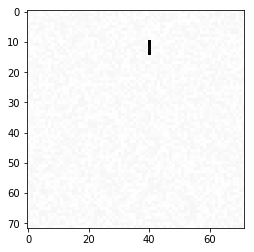

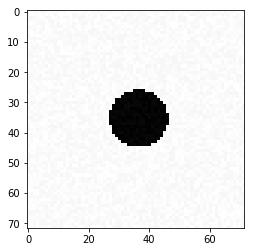

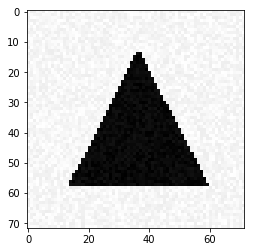

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()


im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

Importing now the library and tools that will be used later on:

In [2]:
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
import matplotlib.cm as cm
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
from keras.layers import advanced_activations, UpSampling2D

Using TensorFlow backend.


Setting the sample size for the exercises to come:

In [3]:
n_rows = 300

# 3 Simple Classification

Build and train a linear classifier in Keras to classify a image into one of the three possible
categories (i.e. rectangle, disk, triangle). Try using the stochastic gradient descent optimizer, then
the Adam optimizer.

Hints: You will have to use the following functions: Sequential, add, Dense (do not forget the
activation), compile, fit, np_utils.to_categorical. For the Adam optimizer, I used a batch size
of 32. You should use a small number of epochs when debugging to see if the optimization seems to
converge correctly.

In [4]:
[X_train, Y_train] = generate_dataset_classification(n_rows, 20)
Y_train2 = keras.utils.to_categorical(Y_train, 3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [5]:
model = Sequential()
nb_neurons = 3
model.add(Dense(nb_neurons, activation = 'softmax', input_shape=(5184,) ))

In [6]:
sgd = SGD(lr=0.01,
    decay=1e-6, momentum=0.9,
    nesterov=True)

In [7]:
model.compile(loss='mean_squared_error',
    optimizer='sgd', metrics=['accuracy'])

In [8]:
model.fit(X_train, Y_train2, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 0s 376us/step - loss: 0.2741 - acc: 0.3767
Epoch 2/10
300/300 [==============================] - 0s 83us/step - loss: 0.2581 - acc: 0.3767
Epoch 3/10
300/300 [==============================] - 0s 86us/step - loss: 0.2939 - acc: 0.3967
Epoch 4/10
300/300 [==============================] - 0s 100us/step - loss: 0.2699 - acc: 0.4767
Epoch 5/10
300/300 [==============================] - 0s 83us/step - loss: 0.2555 - acc: 0.4467
Epoch 6/10
300/300 [==============================] - 0s 83us/step - loss: 0.1627 - acc: 0.6567
Epoch 7/10
300/300 [==============================] - 0s 76us/step - loss: 0.2001 - acc: 0.5500
Epoch 8/10
300/300 [==============================] - 0s 83us/step - loss: 0.2018 - acc: 0.5833
Epoch 9/10
300/300 [==============================] - 0s 90us/step - loss: 0.1270 - acc: 0.7500
Epoch 10/10
300/300 [==============================] - 0s 86us/step - loss: 0.1527 - acc: 0.6367


Really simple model, rather low accuracy with SGD

In [9]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1.0000000e+00, 2.7330887e-37, 0.0000000e+00]], dtype=float32)

In [10]:
X_testR = generate_a_rectangle()
X_testR = X_test.reshape(1, X_testR.shape[0])
model.predict(X_testR)

array([[1.0000000e+00, 2.7330887e-37, 0.0000000e+00]], dtype=float32)

Now with the Adam classifier

In [11]:
model_adam = Sequential()
model_adam.add(Dense(nb_neurons, activation = 'softmax', input_shape=(5184,) ))

model_adam.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [12]:
model_adam.fit(X_train, Y_train2, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 0s 509us/step - loss: 1.6672 - acc: 0.3700
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 1.0385 - acc: 0.562 - 0s 90us/step - loss: 0.8437 - acc: 0.5700
Epoch 3/10
300/300 [==============================] - 0s 103us/step - loss: 0.5276 - acc: 0.7667
Epoch 4/10
300/300 [==============================] - 0s 83us/step - loss: 0.4338 - acc: 0.7967
Epoch 5/10
300/300 [==============================] - 0s 93us/step - loss: 0.3816 - acc: 0.8367
Epoch 6/10
300/300 [==============================] - 0s 100us/step - loss: 0.3110 - acc: 0.9367
Epoch 7/10
300/300 [==============================] - 0s 93us/step - loss: 0.2846 - acc: 0.8967
Epoch 8/10
300/300 [==============================] - 0s 90us/step - loss: 0.2584 - acc: 0.9400
Epoch 9/10
300/300 [==============================] - 0s 100us/step - loss: 0.2155 - acc: 0.9400
Epoch 10/10
300/300 [==============================] - 0s 103us/step - loss: 0.2000 - acc: 0.9

Same model, but with a different optimizer yield much better results!

In [13]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_adam.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [14]:
X_testR = generate_a_rectangle()
X_testR = X_testR.reshape(1, X_testR.shape[0])
model_adam.predict(X_testR)

array([[1., 0., 0.]], dtype=float32)

# 4 Visualization of the Solution

We would like to visualize the weights of the linear classifier. Check the output of the function
model.get_weights(): The first part corresponds to the matrix of the classifier. Its columns have
the same size as the input images, because Keras uses vector-matrix multiplications instead of matrix-
vector multiplications.
 Visualize the 3 columns as images.
Hint: Only two (short) lines of code are required to visualize one column.

In [15]:
model.get_weights()

[array([[ 0.02774716, -0.02963389, -0.01319615],
        [-0.00843493, -0.01673974, -0.0266599 ],
        [ 0.02065042,  0.01058949, -0.00320016],
        ...,
        [ 0.01446627, -0.01978233, -0.01379581],
        [-0.02023774,  0.01445801,  0.00566539],
        [-0.01573737, -0.01332305, -0.00886002]], dtype=float32),
 array([ 0.00127972, -0.00078534, -0.00049439], dtype=float32)]

In [16]:
w = model_adam.get_weights()[0]
print(w)

[[ 0.02624572  0.03202146 -0.03048846]
 [-0.00262007 -0.02069655  0.00108147]
 [ 0.00386567  0.03184772  0.01774832]
 ...
 [ 0.00753051 -0.03161523 -0.02825723]
 [ 0.0291174   0.01470771 -0.01003121]
 [ 0.03313438 -0.0101762   0.00711392]]


In [17]:
column1 = w[:, 0]
column2 = w[:, 1]
column3 = w[:, 2]

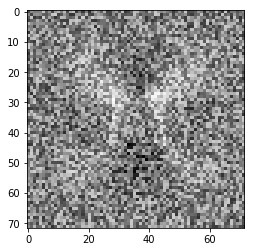

In [18]:
plt.imshow(column1.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = cm.Greys)

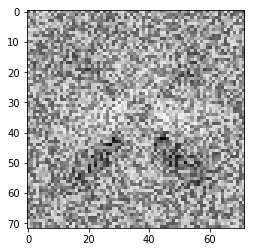

In [19]:
plt.imshow(column2.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = cm.Greys)

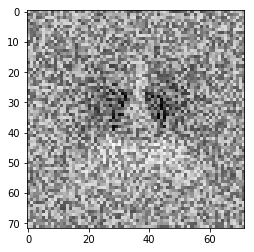

In [20]:
plt.imshow(column3.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = cm.Greys)

# 5 A More Dificult Classification Problem

Now, the shapes are allowed to move within the images and change dimensions. You can generate
the new training set with:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Retrain your linear classifier on this new training set. Add the metrics=['accuracy'] parameter
when calling the compile function to get the classification error in addition to the loss value.
You can generate a test set by calling:
[X_test, Y_test] = generate_test_set_classification()
and evaluate your classifier on this test set by calling:
model.evaluate(X_test, Y_test)
y Train a convolutional (not-to-)deep network on this new dataset. What is the value of the loss
function on this test set when using your deep network?
Hints: You can limit yourself to 1 convolutional layer with 16 5X5 filters, 1 pooling layer, and
one fully connected layer, but you are free to use any other architecture. You are allowed to increase
the number of training samples if you want to.

In [21]:
[X_train, Y_train] = generate_dataset_classification(n_rows, 20, True)
Y_train2 = keras.utils.to_categorical(Y_train, 3)
X_train_conv= X_train.reshape(n_rows,IMAGE_SIZE,IMAGE_SIZE,1)
Y_train_conv= Y_train2.reshape(n_rows, 3)

[X_test, Y_test] = generate_test_set_classification()
X_test2 = X_test.reshape(n_rows, IMAGE_SIZE, IMAGE_SIZE, 1)
Y_test2 = Y_test.reshape(n_rows, 3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Testing the previous model with the new data (position of the figures moves)

In [22]:
model_adam = Sequential()
model_adam.add(Dense(nb_neurons, activation = 'softmax', input_shape=(5184,) ))

model_adam.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [23]:
model_adam.fit(X_train, Y_train2, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 0s 525us/step - loss: 1.8912 - acc: 0.3000
Epoch 2/10
300/300 [==============================] - 0s 93us/step - loss: 1.4101 - acc: 0.3967
Epoch 3/10
300/300 [==============================] - 0s 100us/step - loss: 0.9991 - acc: 0.4933
Epoch 4/10
300/300 [==============================] - 0s 86us/step - loss: 1.1767 - acc: 0.4667
Epoch 5/10
300/300 [==============================] - 0s 90us/step - loss: 1.1730 - acc: 0.4600
Epoch 6/10
300/300 [==============================] - 0s 100us/step - loss: 0.9121 - acc: 0.5833
Epoch 7/10
300/300 [==============================] - 0s 100us/step - loss: 0.9120 - acc: 0.5300
Epoch 8/10
300/300 [==============================] - 0s 93us/step - loss: 0.9557 - acc: 0.5867
Epoch 9/10
300/300 [==============================] - 0s 103us/step - loss: 0.9418 - acc: 0.5700
Epoch 10/10
300/300 [==============================] - 0s 93us/step - loss: 0.9052 - acc: 0.5767


In [24]:
model_adam.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 203us/step


[0.9494343582789103, 0.4700000003973643]

We can see that now that the figure can move, the previous model accuracy went down from the 90% to around 50%

In [25]:
model_conv = Sequential()
model_conv.add(Conv2D(16, kernel_size=5, activation='relu', input_shape = (IMAGE_SIZE,IMAGE_SIZE,1)))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Flatten())
model_conv.add(Dense(50,activation='relu'))
model_conv.add(Dense(3, activation='softmax'))

In [26]:
model_conv.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [27]:
model_conv.fit(X_train_conv, Y_train_conv, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 1.6679 - acc: 0.3433
Epoch 2/10
300/300 [==============================] - 1s 2ms/step - loss: 1.0584 - acc: 0.4800
Epoch 3/10
300/300 [==============================] - 1s 2ms/step - loss: 0.9173 - acc: 0.6000
Epoch 4/10
300/300 [==============================] - 1s 2ms/step - loss: 0.8473 - acc: 0.6267
Epoch 5/10
300/300 [==============================] - 1s 2ms/step - loss: 0.7754 - acc: 0.7267
Epoch 6/10
300/300 [==============================] - 1s 2ms/step - loss: 0.7240 - acc: 0.7433
Epoch 7/10
300/300 [==============================] - 1s 2ms/step - loss: 0.6777 - acc: 0.7867
Epoch 8/10
300/300 [==============================] - 1s 2ms/step - loss: 0.6320 - acc: 0.8100
Epoch 9/10
300/300 [==============================] - 1s 2ms/step - loss: 0.5833 - acc: 0.8233
Epoch 10/10
300/300 [==============================] - 1s 2ms/step - loss: 0.5797 - acc: 0.7933


In [28]:
model_conv.evaluate(X_test2, Y_test2)

300/300 [==============================] - 0s 991us/step


[0.7544525877634685, 0.6466666666666666]

As we can see, the accuracy went up by 20% by adding a convulation layer.

# 6 A Regression Problem

In [29]:
[X_train, Y_train] = generate_dataset_regression(n_rows, 20)
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [30]:
X_train = X_train.reshape(n_rows, IMAGE_SIZE, IMAGE_SIZE, 1).astype('float32')
X_test = X_test.reshape(n_rows, IMAGE_SIZE, IMAGE_SIZE, 1)
Y_train = Y_train.reshape(n_rows, 3, 2)

In [31]:
for i in range(n_rows):
    Y_train[i] = Y_train[i][np.argsort(np.sum(Y_train[i], axis=1)), :]
 

In [32]:
Y_train = np.array([Y_train[i].ravel() for i in range(n_rows)])

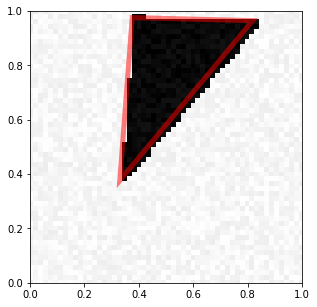

In [33]:
visualize_prediction(X_train[0], Y_train[0])

In [39]:
model_reg = Sequential()
model_reg.add(Conv2D(16, (5,5), activation='relu', padding='same', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
model_reg.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_reg.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model_reg.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_reg.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_reg.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_reg.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_reg.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_reg.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_reg.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_reg.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_reg.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_reg.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_reg.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_reg.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_reg.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_reg.add(Flatten())
model_reg.add(Dense(128, activation='relu'))
model_reg.add(Dense(64, activation='relu'))
model_reg.add(Dense(32, activation='relu'))
model_reg.add(Dense(6))

model_reg.compile(loss='mean_squared_error',
                    optimizer='adam',
                    metrics=['accuracy'])

In [40]:
model_reg.fit(X_train, Y_train, epochs=100, batch_size=32)

Epoch 1/100
300/300 [==============================] - 2s 7ms/step - loss: 0.2529 - acc: 0.3167
Epoch 2/100
300/300 [==============================] - 1s 4ms/step - loss: 0.1479 - acc: 0.0333
Epoch 3/100
300/300 [==============================] - 1s 5ms/step - loss: 0.0825 - acc: 0.3533
Epoch 4/100
300/300 [==============================] - 1s 5ms/step - loss: 0.0672 - acc: 0.3833
Epoch 5/100
300/300 [==============================] - 1s 5ms/step - loss: 0.0643 - acc: 0.3200
Epoch 6/100
300/300 [==============================] - 1s 5ms/step - loss: 0.0637 - acc: 0.3633
Epoch 7/100
300/300 [==============================] - 1s 4ms/step - loss: 0.0617 - acc: 0.3633
Epoch 8/100
300/300 [==============================] - 1s 5ms/step - loss: 0.0610 - acc: 0.3633
Epoch 9/100
300/300 [==============================] - 1s 5ms/step - loss: 0.0566 - acc: 0.3633
Epoch 10/100
300/300 [==============================] - 1s 4ms/step - loss: 0.0538 - acc: 0.4400
Epoch 11/100
300/300 [=================

300/300 [==============================] - 1s 4ms/step - loss: 9.8831e-04 - acc: 0.8867
Epoch 86/100
300/300 [==============================] - 1s 5ms/step - loss: 8.8319e-04 - acc: 0.9267
Epoch 87/100
300/300 [==============================] - 1s 5ms/step - loss: 7.4373e-04 - acc: 0.9233
Epoch 88/100
300/300 [==============================] - 1s 5ms/step - loss: 6.5994e-04 - acc: 0.9167
Epoch 89/100
300/300 [==============================] - 1s 4ms/step - loss: 6.8216e-04 - acc: 0.9067
Epoch 90/100
300/300 [==============================] - 1s 4ms/step - loss: 8.6651e-04 - acc: 0.9067
Epoch 91/100
300/300 [==============================] - 1s 4ms/step - loss: 7.2117e-04 - acc: 0.9100
Epoch 92/100
300/300 [==============================] - 1s 4ms/step - loss: 5.7707e-04 - acc: 0.9267
Epoch 93/100
300/300 [==============================] - 1s 4ms/step - loss: 4.9530e-04 - acc: 0.9400
Epoch 94/100
300/300 [==============================] - 1s 4ms/step - loss: 4.7494e-04 - acc: 0.9200
Epo

In [41]:
model_reg.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 2ms/step


[0.1053882164756457, 0.2699999996026357]

The model I created seems to have a high variance, as my training accuracy is in the 90% while my testing accuracy is in the 30%. I searched for a long time, but could not find the reason for this important variance.

In [42]:
Y_prediction = model_reg.predict(X_test)

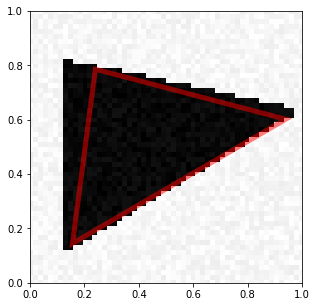

In [110]:
num = np.random.randint(299)
visualize_prediction(X_test[num], Y_prediction[num])

# 7 Image Denoising

First, changing the rectangle and circle generating functions to create two pictures, one with noise, and one without. 

In [112]:
def generate_a_rectangle_noise(noise=100, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V)]


def generate_a_disk_noise(noise=100, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)]

def generate_a_drawing_noise(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata


def generate_a_triangle_noise(noise=100, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    imdataY = generate_a_drawing(figsize, U, V, 0)
    return [imdata, imdataY]


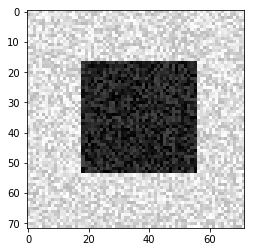

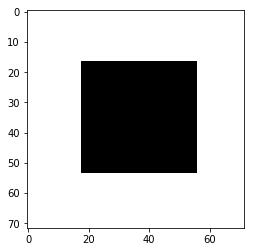

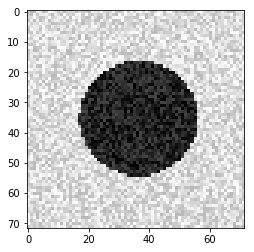

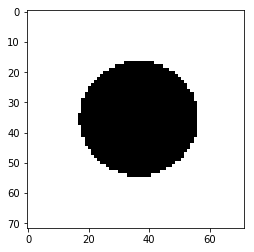

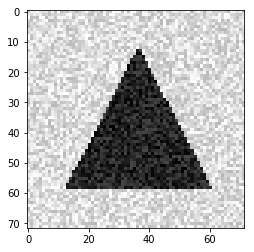

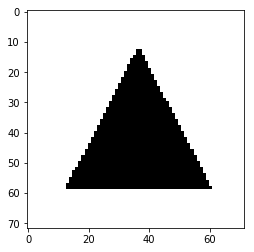

In [113]:
[im, imY] = generate_a_rectangle_noise()
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

plt.imshow(imY.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

[im, imY] = generate_a_disk_noise()
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

plt.imshow(imY.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

[im,imY] = generate_a_triangle_noise()
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

plt.imshow(imY.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

Now, change our data generating functions to create shapes with noise:

In [114]:
def generate_dataset_classification_noise(nb_samples, noise=100, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle_noise()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            [X[i], Y[i]] = generate_a_rectangle_noise(noise)
        elif category == 1: 
            [X[i], Y[i]] = generate_a_disk_noise(noise)
        else:
            [X[i], Y[i]] = generate_a_triangle_noise(noise)
            
        X[i] = (X[i] + noise) / (255 + 2 * noise)
        Y[i] = Y[i] / 255
    return [X, Y]

def generate_test_set_classification_noise():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification_noise(300, 100)
    #Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [115]:
[X_train, Y_train] = generate_dataset_classification_noise(n_rows, 100)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [116]:
[X_test, Y_test] = generate_test_set_classification_noise()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [117]:
X_train = X_train.reshape(n_rows, IMAGE_SIZE, IMAGE_SIZE, 1) 
Y_train = Y_train.reshape(n_rows, IMAGE_SIZE, IMAGE_SIZE, 1)  
X_test = X_test.reshape(n_rows, IMAGE_SIZE, IMAGE_SIZE, 1) 
Y_test = Y_test.reshape(n_rows, IMAGE_SIZE, IMAGE_SIZE, 1) 

In [118]:
model_noise = Sequential()

model_noise.add(Conv2D(32, kernel_size=(3,3),activation='linear',input_shape=(72,72,1), padding='same'))
model_noise.add(advanced_activations.LeakyReLU(alpha=0.1))
model_noise.add(MaxPooling2D(pool_size=(2, 2)))
model_noise.add(Conv2D(64, kernel_size=(3,3),activation='linear', padding='same'))
model_noise.add(advanced_activations.LeakyReLU(alpha=0.1))
model_noise.add(MaxPooling2D(pool_size=(2, 2)))
model_noise.add(Conv2D(32, kernel_size=(3,3),activation='linear', padding='same'))
model_noise.add(advanced_activations.LeakyReLU(alpha=0.1))
model_noise.add(UpSampling2D(size=(2, 2)))
model_noise.add(Conv2D(32, kernel_size=(3,3),activation='linear', padding='same'))
model_noise.add(UpSampling2D(size=(2, 2)))
model_noise.add(advanced_activations.LeakyReLU(alpha=0.1))
model_noise.add(Conv2D(1, kernel_size=(3,3),activation='sigmoid', padding='same'))

In [119]:
model_noise.compile(loss='mean_squared_error',
                    optimizer='adam',
                    metrics=['accuracy'])

In [120]:
model_noise.fit(X_train, Y_train, epochs= 10, batch_size = 20, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/10
240/240 [==============================] - 5s 22ms/step - loss: 0.1548 - acc: 0.7931 - val_loss: 0.1507 - val_acc: 0.7573
Epoch 2/10
240/240 [==============================] - 5s 20ms/step - loss: 0.1203 - acc: 0.7953 - val_loss: 0.1036 - val_acc: 0.7629
Epoch 3/10
240/240 [==============================] - 5s 21ms/step - loss: 0.0513 - acc: 0.9328 - val_loss: 0.0126 - val_acc: 0.9841
Epoch 4/10
240/240 [==============================] - 5s 20ms/step - loss: 0.0073 - acc: 0.9907 - val_loss: 0.0061 - val_acc: 0.9918
Epoch 5/10
240/240 [==============================] - 5s 20ms/step - loss: 0.0046 - acc: 0.9945 - val_loss: 0.0046 - val_acc: 0.9946
Epoch 6/10
240/240 [==============================] - 5s 21ms/step - loss: 0.0042 - acc: 0.9949 - val_loss: 0.0042 - val_acc: 0.9949
Epoch 7/10
240/240 [==============================] - 5s 20ms/step - loss: 0.0043 - acc: 0.9946 - val_loss: 0.0040 - val_acc: 0.9953
Epoch 8/10
240/240 [====

In [121]:
Y_pred_noise = model_noise.predict(X_test)

Text(0.5, 0, 'With no noise prediction')

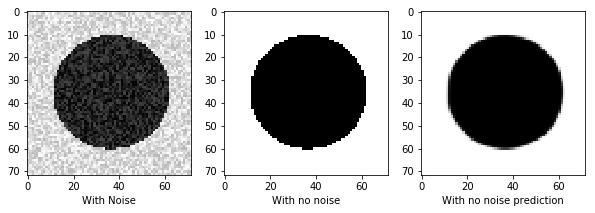

In [122]:
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.subplot(1,3,1)
num = np.random.randint(299)
plt.imshow(X_test[num].reshape(72,72), cmap='gray')
plt.xlabel('With Noise')
plt.subplot(1,3,2)
plt.imshow(Y_test[num].reshape(72,72), cmap='gray')
plt.xlabel('With no noise')
plt.subplot(1,3,3)
plt.imshow(Y_pred_noise[num].reshape(72,72), cmap='gray')
plt.xlabel('With no noise prediction')

In [123]:
model_noise.evaluate(X_test, Y_test)

300/300 [==============================] - 2s 5ms/step


[0.003106369078159332, 0.9963869619369506]

The model shows a high level of accuracy!

In [124]:
pwd

'C:\\Users\\arnau\\Deep Learning MP1'